# IV analyse of juxtacellular data
Data provided by Daniel English and Sam McKenzie

In [147]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from method import IV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import numpy as np
import quantities as pq
import seaborn as sns
import sys
sys.path.append('../exana/'),
from exana.stimulus import plot_psth
from exana.statistics.plot import plot_xcorr, plot_autocorr
from exana.statistics.tools import ccg_significance, correlogram
from method import IV

import scipy
import neo
import exana

import pdb
from scipy.ndimage.filters import gaussian_filter1d as gaussfilt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load files and convert to neo

In [2]:
ses = scipy.io.loadmat('../data/JuxtaGroundTruth.mat')

blks = []

for ses_i in ses['ses'][0]:
    sesi_dict = {'stimTimes': ses_i[0],
                 'name': ses_i[1],
                 'ID': ses_i[2],
                 'juxta_ID': ses_i[3],
                 'times': ses_i[4],
                 'rippleTimes': ses_i[5],}
    blk = neo.Block(name=sesi_dict['name'])
    
    seg = neo.Segment()
    chx_units = neo.ChannelIndex(index=0,
                                 name='units')
    blk.channel_indexes.append(chx_units)
    
    # load spike times
    
    unique_neuron_ids = np.unique(sesi_dict['ID'], axis=0)
    for neuron_id_i in unique_neuron_ids:
        unit_i = neo.Unit(name=str(list(neuron_id_i)),
                          electrode=neuron_id_i[0],
                          cluster=neuron_id_i[1])
        
        spkts_idcs = np.where((sesi_dict['ID']==neuron_id_i).all(axis=1))
        spkts = sesi_dict['times'][spkts_idcs]
        spkts = spkts.flatten()
        spk_train = neo.SpikeTrain(times=spkts,
                                   t_start=np.min(spkts),
                                   t_stop=np.max(spkts),
                                   units='s',
                                   name=str(neuron_id_i))
        spk_train.unit = unit_i
        seg.spiketrains.append(spk_train)
        unit_i.spiketrains.append(spk_train)
        chx_units.units.append(unit_i)
        
    # load stimulation epochs
    stim_start = sesi_dict['stimTimes'][:, 0]
    stim_dur = sesi_dict['stimTimes'][:, 1] - sesi_dict['stimTimes'][:, 0]
    
    epc = neo.Epoch(times=stim_start*pq.s,
                    durations=stim_dur*pq.s,
                    name='Stim',
                    description=sesi_dict['juxta_ID'])
    seg.epochs.append(epc)
    blk.segments.append(seg)
    blks.append(blk)

In [3]:
n_units = []
for i, blk in enumerate(blks):
    units = blk.channel_indexes[0]
    unit_names = [u.name for u in units.children]
    n_units_i = len(unit_names)
    n_units.append(n_units_i)
print('Number of units per session')
print(n_units)

Number of units per session
[6, 12, 18, 6, 25, 35, 31, 32, 37, 32, 25, 40, 32, 38, 25, 24, 14, 21]


## 1) PSTH
### Aim
Determine reasonable latencies for IV analyses.

### 1a) We start by looking at PSTHs of the first session


/opt/conda/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


['[1, 2]', '[1, 3]', '[1, 4]', '[1, 5]', '[1, 6]', '[1, 7]']


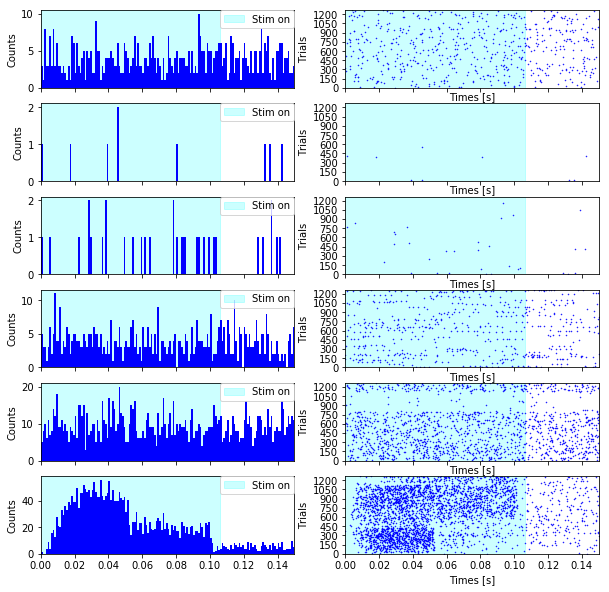

In [4]:
# start with a single example

blk = blks[0]
seg=blk.segments[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]
xlim = [0, 150] * pq.ms


fig, axs = plt.subplots(len(spktrns),2,
                        sharex=True,
                        figsize=(10,10))
for i, spktrn_i in enumerate(spktrns):
    plot_psth(spike_train=spktrn_i,
              epoch=epc,
              xlim=xlim,
              axs=[axs[i, 0], axs[i, 1]],
              hist_binsize=1*pq.ms,
              stim_style='patch',
              stim_color='cyan',
              hist_alpha=1.,
              hist_edgecolor=None, 
              hist_ylabel='Counts',
              rast_size=1);
print([sptr_i.unit.name for sptr_i in spktrns])

### Observation
For a given session, we see the stimulation (blue) and the respective neuron response.
The neuron in the last row is the neuron showing a clear response to the stimulation onset.
The others are not obviously modulated.
In the raster plot in the bottom row on can see that stimulation duration is either 50 ms or 100 ms.
Further one can see that stimulation onset is relatively slow.
Peak response after around 20-30 ms.

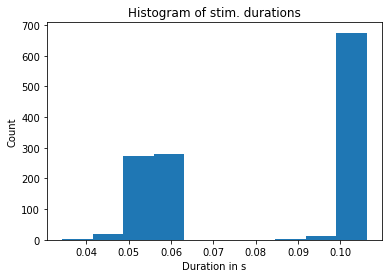

In [5]:
fig, ax = plt.subplots(1)
ax.hist(epc.durations.magnitude)
ax.set_title('Histogram of stim. durations')
ax.set_xlabel('Duration in ' + str(epc.durations.dimensionality))
ax.set_ylabel('Count')
plt.show()

### Observation
Histogram of stimulation durations confirms that stimulation duration is either around 50 ms or 100 ms.

### Conclusion
The slow stimulation response seems to be a problem for proposed IV method using the wald estimator.
It is based on the idea that a spike shortly before the stimulation onset, will render the stimulated neuron refractory.

### Next steps
To get more clarity on whether the IV approach using the binary wald estimator is still feasible, we:
* Quantifiy stimulation response
* Measure refractory period
* Look for evicdence that a spike before the stimulation onset prevented a spike after stimulation onset.

## Latency until first spike
We start again with a single session

In [6]:
blk = blks[8]
seg=blk.segments[0]
units = blk.channel_indexes[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]

juxta_id = list(epc.description[0])
unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
spktr_juxta = unit_juxta.spiketrains[0]

# We collect last spike before and first spike after stimulation onset

spks_bfr_aft = np.zeros((len(epc.times), 3))
# spks_bfr_aft, column 0 - last spike before onset,
# 1 - first spike after onset, 2 - stim onset 


for i, stim_t_i in enumerate(epc.times):
    idx = np.searchsorted(spktr_juxta.times, stim_t_i)
    spks_bfr_aft[i, 0] = spktr_juxta.times[idx-1]
    spks_bfr_aft[i, 1] = spktr_juxta.times[idx]
    spks_bfr_aft[i, 2] = stim_t_i

ltnc_onst = spks_bfr_aft[:, 1] - spks_bfr_aft[:, 2]
ltnc_prevspk = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 2]

# look only at those values within short interval, {-dt, dt} with regard to stimulation
dt = 0.01

bool_onst = ltnc_onst<dt

ltnc_onst_lim = ltnc_onst[bool_onst]
ltnc_prevspk_lim = ltnc_prevspk[bool_onst]



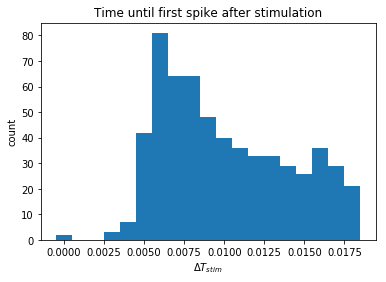

Peak at [s]: 0.006


In [7]:
H, bins = np.histogram(ltnc_onst, bins=np.arange(0., 0.02, 0.001))

fig, ax = plt.subplots(1)
ax.bar(bins[:-1], H, width=0.001)
ax.set_xlabel(r'$\Delta T_{stim}$')
ax.set_ylabel('count')
ax.set_title('Time until first spike after stimulation')

plt.show()

print('Peak at [s]: ' + str(np.round(bins[np.argmax(H)], 3)))

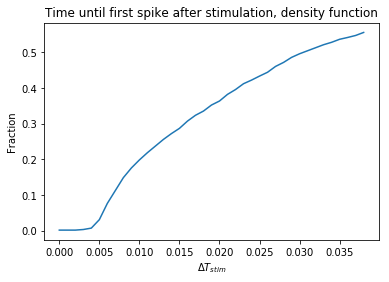

In [8]:
H, bins = np.histogram(ltnc_onst, bins=np.arange(0., .04, 0.001))
H = H / len(epc.times)
fig, ax = plt.subplots(1)
H_cum = np.cumsum(H)
ax.plot(bins[:-1],H_cum)
ax.set_xlabel(r'$\Delta T_{stim}$')
ax.set_ylabel('Fraction')
ax.set_title('Time until first spike after stimulation, density function')

plt.show()


### Observation
Both the histogram and the density function plot show that for this dataset the first spikes are to be expected after 5 ms after stimulation onset.
One can see that it takes roughly 20 ms, to have a 35% chance of response.

### Next step
Are 5 ms much longer than the refractory period?
We will do autocorrelation to get an estimate on how long the refractory period is.

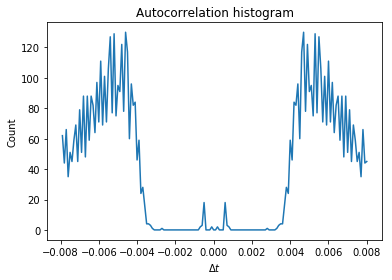

In [47]:
cnt, bins = correlogram(spktr_juxta, auto=True, limit=0.008*pq.s, binsize=0.0001*pq.s)

fig, ax = plt.subplots(1)
ax.set_xlabel(r'$\Delta t$')
ax.set_ylabel('Count')
ax.set_title('Autocorrelation histogram')
ax.plot(bins, cnt)
#ax.set_ylim([0, 400])


### Observation
We see from the autocorrelation plot that the refrctory period of the juxtacellular stimulated neuron here is around 4 ms.
This is shorter than the minimal response time of the stimulation.


### Next step
To see whether this observation is consitent, we repeat the same for all available datasets and average the results.

##  We plot the very same for the other data sets

In [42]:
bins_H = np.arange(0., .04, 0.001)
H = np.zeros((len(blks), len(bins_H)-1))

autocorr_limit = 0.008 * pq.s
autocorr_binsize =  0.0001 * pq.s
autocorr = np.zeros((len(blks),
                     int(autocorr_limit.magnitude/autocorr_binsize.magnitude*2)))

for k, blk in enumerate(blks):
    print(blk.name)
    seg=blk.segments[0]
    units = blk.channel_indexes[0]
    spktrns = seg.spiketrains
    epc = seg.epochs[0]

    juxta_id = list(epc.description[0])
    unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
    spktr_juxta = unit_juxta.spiketrains[0]

    # We collect last spike before and first spike after stimulation onset
    
    times = epc.times[epc.times<spktr_juxta.times[-1]]
    spks_bfr_aft = np.zeros((len(times), 3))
    # spks_bfr_aft, column 0 - last spike before onset,
    # 1 - first spike after onset, 2 - stim onset 

    for i, stim_t_i in enumerate(times):
        idx = np.searchsorted(spktr_juxta.times, stim_t_i)
        if idx>=len(spktr_juxta.times):
            spks_bfr_aft[i, 1] = 10e10
        else:
            spks_bfr_aft[i, 1] = spktr_juxta.times[idx]
        spks_bfr_aft[i, 0] = spktr_juxta.times[idx-1]
        spks_bfr_aft[i, 2] = stim_t_i

#    for i, stim_t_i in enumerate(epc.times):
#        idx = np.searchsorted(spktr_juxta.times, stim_t_i)
#        spks_bfr_aft[i, 0] = spktr_juxta.times[idx-1]
#        spks_bfr_aft[i, 1] = spktr_juxta.times[idx]
#        spks_bfr_aft[i, 2] = stim_t_i
        
    ltnc_onst = spks_bfr_aft[:, 1] - spks_bfr_aft[:, 2]
    ltnc_prevspk = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 2]
    try:
        H_k, bins_H = np.histogram(ltnc_onst, bins=bins_H)
        H_k = H_k / len(times)
        H[k, :] = np.cumsum(H_k)
        cnt, bins_autocorr = correlogram(spktr_juxta, auto=True,
                                limit=autocorr_limit,
                                binsize=autocorr_binsize,
                                density=True)

        autocorr[k, : ] = cnt
    except:
        print('Warning: Error occured in session: ' + str(k))
        pdb.set_trace()
        pass
    
    # look only at those values within short interval, {-dt, dt} with regard to stimulation
#    dt = 0.01

#    bool_onst = ltnc_onst<dt

#    ltnc_onst_lim = ltnc_onst[bool_onst]
#    ltnc_prevspk_lim = ltnc_prevspk[bool_onst]

#    argsrt_onst = np.argsort(ltnc_onst_lim)
#    fig, ax = plt.subplots(1)
#    ax.scatter(ltnc_onst_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='r')
#    ax.set_xlim([-0.01, 0.01])

#    ax.scatter(ltnc_prevspk_lim[argsrt_onst], range(len(ltnc_onst_lim)), marker='|',c='b')
#    ax.set_xlim([-0.01, 0.01])

#    ax.axvline(0)

#    ax.set_xlabel(r'$\Delta T_{stim}$')
#    ax.set_ylabel('Sorted Trials')

#    ax.set_title('Session ' + str(k) + ' - Sorted spikes before and after stimulation')
#plt.show()

['/media/sam/SM4/SeqGen/JS13/20160930_160930_150712']
['/media/sam/SM4/SeqGen/JS13/20161005_161005_110726']
['/media/sam/SM4/SeqGen/JS13/20161005_161005_121544']
['/media/sam/SM4/SeqGen/JS5/20160726_124241_140027']
['/media/sam/SM4/SeqGen/RM10/20170615a']
['/media/sam/SM4/SeqGen/RM10/20170616d']
['/media/sam/SM4/SeqGen/RM10/20170616e']
['/media/sam/SM4/SeqGen/RM14/20170711b']
['/media/sam/SM4/SeqGen/RM14/20170711c']
['/media/sam/SM4/SeqGen/RM14/20170711d']
['/media/sam/SM4/SeqGen/RM14/20170711e']
['/media/sam/SM4/SeqGen/RM14/20170711f']
['/media/sam/SM4/SeqGen/RM14/20170711g']
['/media/sam/SM4/SeqGen/RM14/20170711h']
['/media/sam/SM4/SeqGen/RM14/20170712a']
['/media/sam/SM4/SeqGen/RM14/20170712c']
['/media/sam/SM4/SeqGen/JS13/20161005_161005_133644']
['/media/sam/SM4/SeqGen/JS6/20160831_160831_154407']


In [39]:
correlogram?

Text(0.5,1,'Time until first spike after stimulation, density function')

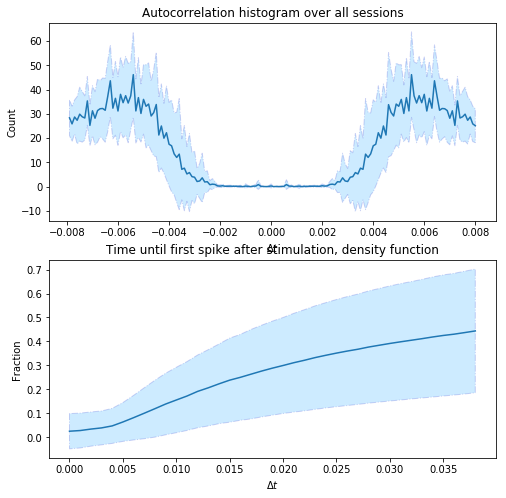

In [58]:
fig, ax = plt.subplots(2,1, figsize=(8,8))
H_mean = np.mean(H, axis=0)
H_std = np.std(H, axis=0)
autocorr_mean = np.mean(autocorr, axis=0)
autocorr_std = np.std(autocorr, axis=0)

bins_H

ax[0].plot(bins_autocorr,autocorr_mean)
ax[0].fill_between(bins_autocorr,
                    autocorr_mean-autocorr_std,
                    autocorr_mean+autocorr_std,
                    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                    linewidth=1, linestyle='dashdot', antialiased=True)
ax[0].set_xlabel(r'$\Delta t$')
ax[0].set_ylabel('Count')
ax[0].set_title('Autocorrelation histogram over all sessions')

ax[1].plot(bins_H[:-1],H_mean)
ax[1].fill_between(bins_H[:-1],
                    H_mean-H_std,
                    H_mean+H_std,
                    alpha=0.2, edgecolor='#1B2ACC', facecolor='#089FFF',
                    linewidth=1, linestyle='dashdot', antialiased=True)
ax[1].set_xlabel(r'$\Delta t$')
ax[1].set_ylabel('Fraction')
ax[1].set_title('Time until first spike after stimulation, density function')

### Observation
Autocorrelation: Across all sessions, juxtacellular stimulated neurons have a refractory period of at least 0.002 ms.
Density function: Within 20 ms we can only expect only 30 % of trials to be succesful.
Within the first 2 ms, only around 3% of trials are succesful.

## IV wald estimate test
We expect the wald estimate to be difficult.
If we chose a very small time window (like 4 ms), our observations are dominated by events during which no spike occurs.
If we otherwise choose a bigger time window, we may have several spikes in that window and the core idea of the refractoryness does not hold longer.

We will compare the IV results with the spike transmission probability by English and McKenzie.

In [210]:
time_limit=0.04*pq.s
binsize=0.002*pq.s
peak_wndw = [0.0008, 0.0028]
ltnc_syn = 0.003 # in s

iv_window = [0.005, 0.02] # in s

syn_strength = np.empty((len(iv_window), len(blks)), dtype=np.object)
for i, iv_i in enumerate(iv_window):
    for k, blk in enumerate(blks):
        print(k)
        seg=blk.segments[0]
        units = blk.channel_indexes[0]
        spktrns = seg.spiketrains
        epc = seg.epochs[0]

        juxta_id = list(epc.description[0])
        unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
        spktr_juxta = unit_juxta.spiketrains[0]

        syn_strength[i, k] = []

        for spktr_i in spktrns:
            pcausal, pfast, bins, cch, cch_s = ccg_significance(
                spktr_juxta, spktr_i,
                limit=time_limit, binsize=binsize,
                hollow_fraction=0.6,
                width=0.01*pq.s)
            bool_cntctd = np.any(np.logical_and.reduce((pcausal < sig_level,
                                                        pfast < sig_level,
                                                        peak_wndw[0]<=bins,
                                                        bins<=peak_wndw[1])))
            if bool_cntctd:
                mask = (bins >= peak_wndw[0]) & (bins <= peak_wndw[1])
                trans_prob = np.sum(cch[mask] - cch_s[mask]) / len(spktr_juxta)
                try:   
                    iv = IV(spktr_juxta.times.magnitude,
                            spktr_i.times.magnitude,
                            epc.times.magnitude,
                            iv_i, ltnc_syn)
                except:
                    pdb.set_trace()
                syn_strength[i, k].append([trans_prob, iv.wald])

0
1
2


/home/jovyan/work/instrumentalVariable/causal-optoconnectics/method.py:55: RuntimeWarning: Mean of empty slice.
  return(ys.mean() - ysr.mean())
/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
0
1


KeyboardInterrupt: 

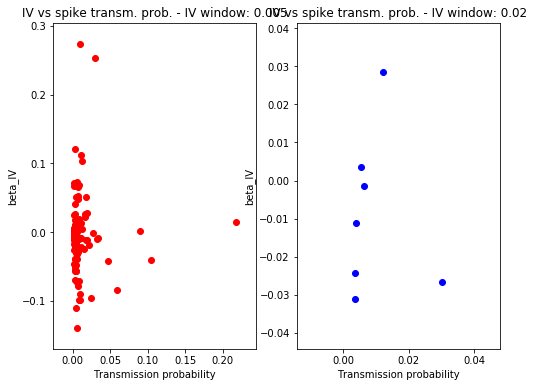

In [212]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))

res_short = np.vstack([ls for ls in list(syn_strength[0, :]) if hasattr(ls, '__len__') and len(ls)>0])
ax[0].scatter(res_short[:, 0], res_short[:, 1], c='r', label=iv_window[0])
ax[0].set_xlabel('Transmission probability')
ax[0].set_ylabel('beta_IV')
ax[0].set_title('IV vs spike transm. prob. - IV window: ' + str(iv_window[0]))

res_long = np.vstack([ls for ls in list(syn_strength[1, :]) if hasattr(ls, '__len__') and len(ls)>0])
ax[1].scatter(res_long[:, 0], res_long[:, 1], c='b', label=iv_window[1])
ax[1].set_xlabel('Transmission probability')
ax[1].set_ylabel('beta_IV')
ax[1].set_title('IV vs spike transm. prob. - IV window: ' + str(iv_window[1]))

plt.show()

### Observation
We get negative values, which is strange.

## Conditional cross correlations as alternative to Wald estimate based on refractory period.
An alternative way of using causal inference in this context is to exploid the fact that the stimulations occur at randomized times.
This should exclude any confounding by a general network up or down states.

We calculate cross-correlograms with a larger time window of stimulation onset and spikes of the post-synaptic neuron.
If the presynaptic neuron is the only connection between stimulus and postsynaptic neuron, then there should be a peak in the cross correlogram between pre- and post only if pre fired.

### First we look at the cross-correlations between stimulus onset, pre and postsynaptic cell without conditioning

In [120]:
# Block 1
blk = blks[4]
seg=blk.segments[0]
units = blk.channel_indexes[0]
spktrns = seg.spiketrains
epc = seg.epochs[0]
juxta_id = list(epc.description[0])
print(juxta_id)
unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
spktr_juxta = unit_juxta.spiketrains[0]

#fig = plt.figure(figsize=(15,15))
#xcorr, fig = plot_xcorr(spktrns, fig=fig, acorr=False, time_limit=0.04*pq.s, binsize=0.002*pq.s)
#plt.show()

[1, 26]


In [121]:
#sel = '[1, 12]'
sel = '[1, 24]'  # ses 4
 
#sel = ['[1, 6]', '[1, 12]']
sig_level = 0.01

spktr_sel = [sptr_i for sptr_i in spktrns if sptr_i.unit.name == sel][0]

pcausal, pfast, bins, ccg, ccg_smoothed = ccg_significance(
    spktr_juxta,
    spktr_sel,
    binsize=0.0004*pq.s,
    limit=0.028*pq.s,
    hollow_fraction=0.6,
    width=0.01*pq.s)

In [122]:
bool_cntctd = np.any(np.logical_and.reduce((pcausal < sig_level, pfast < sig_level, 0.0008<bins, bins<0.0028)))
print(str(juxta_id) + ' connected to ' + sel + ': ' + str(bool_cntctd))

[1, 26] connected to [1, 24]: True


In [123]:
mask = (bins > 0.0008) & (bins < 0.0028)
trans_prob = sum(ccg[mask] - ccg_smoothed[mask]) / len(spktr_sel)
print('Transition probability: ' + str(np.round(trans_prob, 3)))

Transition probability: 0.022


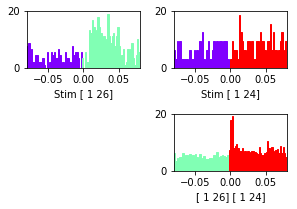

In [124]:
xcorr, fig = plot_xcorr([epc, spktr_juxta, spktr_sel], acorr=False, time_limit=0.08*pq.s, binsize=0.002*pq.s) 

### Observation
There is a clear peak in the cross correlogram between stimulation onset and postsynaptic neuron [1,24].
Further we see, that the time difference in this correlogram, matches with the sum of the the delays Stim->Pre and Pre->Post.

### Alternative visualization
We sort trials in descending order by the delay between stimulation onset and first spike of the presynaptic neuron.
Following the same ordering, we plot postsynaptic spikes.


In [125]:
spks_bfr_aft = np.zeros((len(epc.times), 4), dtype=object)

# spks_bfr_aft, columns:
# 0 - first spike after onset,
# 1 - spikes in time window before and after stimulation, relative time
# 2 - spikes in time window of postsynaptic neuron
# 3 - stimulation times
dt = 0.05* pq.s
for i, stim_t_i in enumerate(epc.times):
    try:
        idx = np.searchsorted(spktr_juxta.times, stim_t_i)
        idx_start = np.searchsorted(spktr_juxta.times, stim_t_i-dt)
        idx_stop = np.searchsorted(spktr_juxta.times, stim_t_i+dt)
        spks_bfr_aft[i, 0] = spktr_juxta.times[idx]
        spks_bfr_aft[i, 1] = spktr_juxta.times[idx_start:idx_stop]-stim_t_i
        idx_post_start = np.searchsorted(spktr_sel.times, stim_t_i-dt)
        idx_post_stop = np.searchsorted(spktr_sel.times, stim_t_i+dt)    
        spks_bfr_aft[i, 2] = spktr_sel.times[idx_post_start:idx_post_stop]-stim_t_i
        spks_bfr_aft[i, 3] = stim_t_i
    except:
        pass

ltnc_onst = spks_bfr_aft[:, 0] - spks_bfr_aft[:, 3]
argsrt_onst = np.argsort(ltnc_onst)

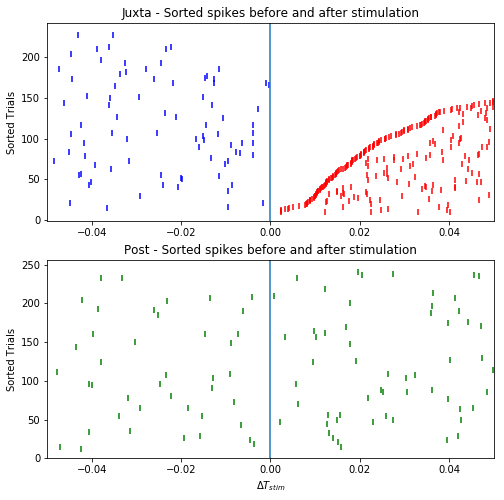

In [126]:
fig, ax = plt.subplots(2,1, figsize=(8,8))

n_trials = len(ltnc_onst)

for i, argsrt_i in enumerate(argsrt_onst):
    try:
        for j in spks_bfr_aft[argsrt_i, 1]:
            if j < 0:
                ax[0].scatter(j, i, marker='|',c='b')
            if j >= 0:
                ax[0].scatter(j, i, marker='|',c='r')
        for j in spks_bfr_aft[argsrt_i, 2]:
                ax[1].scatter(j, i, marker='|',c='g')  
    except:
        pass
ax[0].set_xlim([-dt, dt])
ax[1].set_xlim([-dt, dt])

#ax.scatter(spks_bfr_aft[argsrt_onst, 2], range(n_trials), marker='|',c='b')
#ax.set_xlim([-dt, dt])

ax[0].axvline(0)
ax[1].axvline(0)

ax[1].set_xlabel(r'$\Delta T_{stim}$')
ax[0].set_ylabel('Sorted Trials')
ax[1].set_ylabel('Sorted Trials')

ax[0].set_title('Juxta - Sorted spikes before and after stimulation')
ax[1].set_title('Post - Sorted spikes before and after stimulation')

plt.show()

### Observation
From this plot, we would first expect, that those trials with short latency between stimulation onset and presynaptic spike, have a reduced density of spikes before the stimulation to account for the refractory period.
This is not clearly visible.
Further from this plot it is difficult to see an effect of pre-synaptic on post-synaptic firing.

## Conditioned cross correlation
We do cross correlation of each trial and average those where the pre-synaptic neuron spiked and those where it did not spike.

In [194]:
dt = 0.02 * pq.s
binsize = 0.002 * pq.s

corr_s =  np.zeros(int(2*dt/binsize))
corr_sr =  np.zeros(int(2*dt/binsize))
cnt_s = 0.
cnt_sr = 0.

for i, stim_t_i in enumerate(epc.times):
    try:
        idx_start = np.searchsorted(spktr_juxta.times, stim_t_i)
        idx_stop = np.searchsorted(spktr_juxta.times, stim_t_i+dt)
        spks_pre = spktr_juxta.times[idx_start:idx_stop]
        idx_post_start = np.searchsorted(spktr_sel.times, stim_t_i-dt)
        idx_post_stop = np.searchsorted(spktr_sel.times, stim_t_i+dt)    
        spks_post = spktr_sel.times[idx_post_start:idx_post_stop]
        corr, bins = correlogram(np.array([(stim_t_i.magnitude)]),
                                 spks_post.magnitude,
                                 binsize=binsize.magnitude,
                                 limit=dt.magnitude)
        if np.any(spks_pre):
            corr_s = corr_s + corr
            cnt_s += 1.
        elif not np.any(spks_pre):
            corr_sr += corr
            cnt_sr += 1.
    except:
        pass
corr_s /= cnt_s
corr_sr /= cnt_sr

bool_pos = bins>0
bins = bins[bool_pos]

corr_s = corr_s[bool_pos]
corr_sr = corr_sr[bool_pos]

corr_s_mean = np.mean(corr_s)
corr_sr_mean = np.mean(corr_sr)

corr_s_filt = gaussfilt(corr_s, sigma=1., mode='constant', cval=corr_s_mean)
corr_sr_filt = gaussfilt(corr_sr, sigma=1., mode='constant', cval=corr_sr_mean)

diff_corr = corr_s_filt - corr_sr_filt
diff_corr[diff_corr < 0] = 0.

auc = np.trapz(diff_corr, bins)

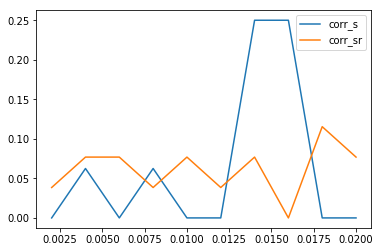

In [165]:
fig, ax = plt.subplots(1)
ax.plot(bins, corr_s, label='corr_s')
ax.plot(bins, corr_sr, label='corr_sr')
ax.legend()
plt.show()

### Observation
corr_s describes the correlogram of those trials where presynaptic neuron spiked, and corr_sr where it did not fire.
We do not have very many datapoints and the therefore the correlogram looks cornered, but the effect is clear.
We should now smoothen both and subtract corr_sr as baseline.
The resulting area under the blue curve is considered to be the synaptic strength between pre- and postsynaptic cell.

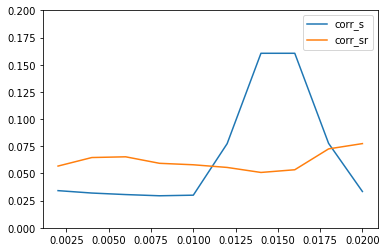

In [192]:
fig, ax = plt.subplots(1)
ax.plot(bins, corr_s_filt, label='corr_s',)
ax.plot(bins, corr_sr_filt, label='corr_sr')
ax.set_ylim([0, 0.2])
ax.legend()
plt.show()

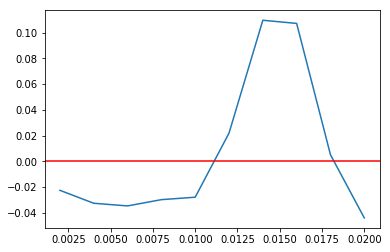

Area under curve: 0.000487321964721


In [195]:
fig, ax = plt.subplots(1)
ax.plot(bins, corr_s_filt - corr_sr_filt)
ax.axhline(0, c='r')
plt.show()
print('Area under curve: ' + str(auc))

### Next step
We repeat this now for all sessions and compare area under curve to spike transmission probability.

In [202]:
time_limit=0.04*pq.s
binsize=0.002*pq.s
peak_wndw = [0.0008, 0.0028]
ltnc_syn = 0.003 # in s

dt_condt_xcorr = 0.02 * pq.s
binsize_condt_xcorr = 0.002 * pq.s


syn_strength = []
for k, blk in enumerate(blks):
    print(k)
    seg=blk.segments[0]
    units = blk.channel_indexes[0]
    spktrns = seg.spiketrains
    epc = seg.epochs[0]

    juxta_id = list(epc.description[0])
    unit_juxta = [u for u in units.children if u.name == str(juxta_id)][0]
    spktr_juxta = unit_juxta.spiketrains[0]

    for spktr_i in spktrns:
        pcausal, pfast, bins, cch, cch_s = ccg_significance(
            spktr_juxta, spktr_i,
            limit=time_limit, binsize=binsize,
            hollow_fraction=0.6,
            width=0.01*pq.s)
        bool_cntctd = np.any(np.logical_and.reduce((pcausal < sig_level,
                                                    pfast < sig_level,
                                                    peak_wndw[0]<=bins,
                                                    bins<=peak_wndw[1])))
        if bool_cntctd:
            mask = (bins >= peak_wndw[0]) & (bins <= peak_wndw[1])
            trans_prob = np.sum(cch[mask] - cch_s[mask]) / len(spktr_juxta)


            corr_s =  np.zeros(int(2*dt_condt_xcorr/binsize_condt_xcorr))
            corr_sr =  np.zeros(int(2*dt_condt_xcorr/binsize_condt_xcorr))
            cnt_s = 0.
            cnt_sr = 0.

            for i, stim_t_i in enumerate(epc.times):
                try:
                    idx_start = np.searchsorted(spktr_juxta.times, stim_t_i)
                    idx_stop = np.searchsorted(spktr_juxta.times, stim_t_i+dt)
                    spks_pre = spktr_juxta.times[idx_start:idx_stop]
                    idx_post_start = np.searchsorted(spktr_i.times, stim_t_i-dt)
                    idx_post_stop = np.searchsorted(spktr_i.times, stim_t_i+dt)    
                    spks_post = spktr_i.times[idx_post_start:idx_post_stop]
                    corr, bins = correlogram(np.array([(stim_t_i.magnitude)]),
                                             spks_post.magnitude,
                                             binsize=binsize.magnitude,
                                             limit=dt.magnitude)
                    if np.any(spks_pre):
                        corr_s = corr_s + corr
                        cnt_s += 1.
                    elif not np.any(spks_pre):
                        corr_sr += corr
                        cnt_sr += 1.
                except:
                    pass
            corr_s /= cnt_s
            corr_sr /= cnt_sr

            bool_pos = bins>0
            bins = bins[bool_pos]

            corr_s = corr_s[bool_pos]
            corr_sr = corr_sr[bool_pos]

            corr_s_mean = np.mean(corr_s)
            corr_sr_mean = np.mean(corr_sr)

            corr_s_filt = gaussfilt(corr_s, sigma=1., mode='constant', cval=corr_s_mean)
            corr_sr_filt = gaussfilt(corr_sr, sigma=1., mode='constant', cval=corr_sr_mean)

            diff_corr = corr_s_filt - corr_sr_filt
            diff_corr[diff_corr < 0] = 0.

            auc = np.trapz(diff_corr, bins)

            syn_strength.append([trans_prob, auc])

0
1
2


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in less


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


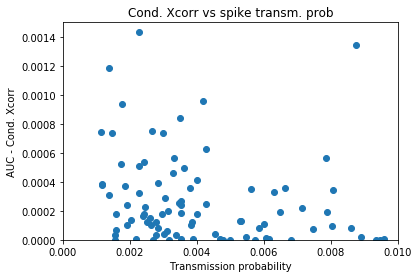

In [209]:
fig, ax = plt.subplots(1)

syn_strength = np.array(syn_strength)

ax.scatter(syn_strength[:, 0], syn_strength[:, 1])
ax.set_ylim([0., 0.0015])
ax.set_xlim([0., 0.01])
ax.set_xlabel('Transmission probability')
ax.set_ylabel('AUC - Cond. Xcorr')
ax.set_title('Cond. Xcorr vs spike transm. prob')

plt.show()

### Observation
Many cells with relatively high spike transmission probability, have zero area under the curve in the conditional cross-correlation.
This would suggest, that they are not connected, despite being detected as connected by the classical cross-correlation method.
But what if it is just a consequence of low spike numbers?

# TODO
* Vizualize AUCs of more examples.
* Can we identify some statistical criteria to determine which AUC value determines a significant connection or a spurious correlation?
* Peaks in cross-correlation histogramms between stimulus onset and postsynaptic neuron will always be smeared out by the variying latency of the presynaptic neuron. Is there a way to compensate for this?